# STAN (ST-based)
[STAN](https://www.biorxiv.org/content/10.1101/2024.06.26.600782v1) [1] is a computational framework for inferring spatially informed transcription factor activity across cellular contexts. Specifically, STAN is a linear mixed-effects computational method that predicts spot-specific, spatially informed TF activities by integrating curated TF-target gene priors, mRNA expression, spatial coordinates, and morphological features from corresponding imaging data.

[1] Zhang, Linan, et al. "STAN, a computational framework for inferring spatially informed transcription factor activity across cellular contexts." _bioRxiv_ (2024): 2024-06.

![alt text](https://github.com/osmanbeyoglulab/Tutorials-on-ISMB-2024/blob/main/hands-on_tutorial/session-1/resources_stan/stan.png?raw=true)

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scanpy as sc

from anndata import AnnData
from scipy.stats import pearsonr, spearmanr, wilcoxon
from sklearn.metrics import mean_squared_error
import squidpy as sq

import warnings 
warnings.filterwarnings('ignore') 

import stan
import auxiliary_stan as aux
figsize = aux.figsize
fontsize = aux.fontsize

## Loading the spatial transcriptomics  data
For this tutorial, we will analyze a Visium spatial transcriptomics dataset of a human lymph node freely available from [10X Genomics](https://support.10xgenomics.com/spatial-gene-expression/datasets/1.0.0/V1_Human_Lymph_Node). The following command downloads 47.4 MB of data upon the first call and stores it in `data/V1_Human_Lymph_Node/`, including the high-resolution tissue image.

In [2]:
adata = sc.datasets.visium_sge(sample_id="V1_Human_Lymph_Node")
adata.var_names_make_unique()
adata

AnnData object with n_obs × n_vars = 4035 × 36601
    obs: 'in_tissue', 'array_row', 'array_col'
    var: 'gene_ids', 'feature_types', 'genome'
    uns: 'spatial'
    obsm: 'spatial'

[<Axes: title={'center': 'H&E Stain'}, xlabel='spatial1', ylabel='spatial2'>]

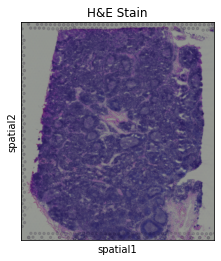

In [3]:
sc.pl.spatial(adata, show=False, title="H&E Stain")

We assign germinal centers (GCs) and cell type to each spot [2]. The resource files can be downloaded from [here](https://raw.githubusercontent.com/vitkl/cell2location_paper/1c645a0519f8f27ecef18468cf339d35d99f42e7/notebooks/selected_results/lymph_nodes_analysis/CoLocationModelNB4V2_34clusters_4039locations_10241genes_input_inferred_V4_batch1024_l2_0001_n_comb50_5_cps5_fpc3_alpha001/W_cell_density.csv) and [here](https://raw.githubusercontent.com/vitkl/cell2location_paper/1c645a0519f8f27ecef18468cf339d35d99f42e7/notebooks/selected_results/lymph_nodes_analysis/CoLocationModelNB4V2_34clusters_4039locations_10241genes_input_inferred_V4_batch1024_l2_0001_n_comb50_5_cps5_fpc3_alpha001/manual_GC_annot.csv). 

[2] Kleshchevnikov, Vitalii, et al. "Cell2location maps fine-grained cell types in spatial transcriptomics." _Nature Biotechnology_ 40.5 (2022): 661-671.

In [4]:
celltypes = pd.read_csv("resources_stan/W_cell_density.csv", index_col=0)
gc_annotation = pd.read_csv("resources_stan/manual_GC_annot.csv", index_col=0).fillna(0).replace("GC", 1)

obs_names = np.intersect1d(celltypes.index, adata.obs_names)
adata = adata[obs_names]
celltypes = celltypes.loc[obs_names]
gc_annotation = gc_annotation.loc[obs_names]
adata.obsm['celltype'] = celltypes
adata.obsm['celltype'].columns = [x.replace('mean_spot_factors','') for x in adata.obsm['celltype'].columns]
adata.obsm['celltype_raw'] = adata.obsm['celltype'].copy()
adata.obsm['celltype'] = adata.obsm['celltype'].divide(adata.obsm['celltype'].sum(axis=1), axis=0)
adata.obs['germinal_center'] = gc_annotation
adata.obs['germinal_center'] = adata.obs['germinal_center'].map({0: "Other", 1: "GC"})

In [5]:
adata.obsm['celltype'].head()

B_Cycling   B_GC_DZ   B_GC_LZ  B_GC_prePB     B_IFN  \
AAACAAGTATCTCCCA-1   0.014304  0.004291  0.009838    0.001631  0.007460   
AAACAATCTACTAGCA-1   0.010970  0.003140  0.003121    0.010249  0.023918   
AAACACCAATAACTGC-1   0.016023  0.004800  0.007748    0.002735  0.002764   
AAACAGAGCGACTCCT-1   0.024432  0.005082  0.009965    0.004315  0.368534   
AAACAGCTTTCAGAAG-1   0.004670  0.004172  0.010534    0.002318  0.009373   

                    B_activated     B_mem   B_naive  B_plasma   B_preGC  ...  \
AAACAAGTATCTCCCA-1     0.058387  0.066087  0.176268  0.071517  0.034278  ...   
AAACAATCTACTAGCA-1     0.002999  0.004663  0.006454  0.007097  0.029351  ...   
AAACACCAATAACTGC-1     0.053791  0.115564  0.104310  0.035633  0.065812  ...   
AAACAGAGCGACTCCT-1     0.002072  0.001441  0.005292  0.007063  0.030701  ...   
AAACAGCTTTCAGAAG-1     0.037803  0.253315  0.294039  0.010730  0.057246  ...   

                    T_CD4+_TfH  T_CD4+_TfH_GC  T_CD4+_naive  T_CD8+_CD161+  \
AAACAAGTATCTCCCA-1    0.022072       0.008777      0.099347       0.014532   
AAACAATCTACTAGCA-1    0.020164       0.010402      0.460768       0.009193   
AAACACCAATAACTGC-1    0.015546       0.009021      0.056641       0.010446   
AAACAGAGCGACTCCT-1    0.009410       0.007992      0.152817       0.006901   
AAACAGCTTTCAGAAG-1    0.006667       0.018914      0.092688       0.003240   

                    T_CD8+_cytotoxic  T_CD8+_naive   T_TIM3+     T_TfR  \
AAACAAGTATCTCCCA-1          0.024978      0.027564  0.053307  0.011292   
AAACAATCTACTAGCA-1          0.027489      0.054988  0.038013  0.033988   
AAACACCAATAACTGC-1          0.024629      0.014912  0.059203  0.007736   
AAACAGAGCGACTCCT-1          0.031141      0.021395  0.054518  0.019565   
AAACAGCTTTCAGAAG-1          0.006798      0.007088  0.017947  0.006130   

                      T_Treg      VSMC  
AAACAAGTATCTCCCA-1  0.023694  0.023908  
AAACAATCTACTAGCA-1  0.060476  0.019545  
AAACACCAATAACTGC-1  0.010822  0.022477  
AAACAGAGCGACTCCT-1  0.030137  0.010812  
AAACAGCTTTCAGAAG-1  0.007050  0.006954  

[5 rows x 34 columns]

We perform some basic filtering of genes and spots. Basic preprocessing workflow can be found [here](https://scanpy.readthedocs.io/en/stable/tutorials/spatial/basic-analysis.html).

In [6]:
sc.pp.filter_genes(adata, min_cells=5)
sc.pp.filter_cells(adata, min_counts=5000)
adata.layers['raw'] = adata.X
adata.obs['ncounts'] = adata.to_df('raw').T.sum()

Write the preprocessed data to file.

In [7]:
!mkdir outputs_stan/
adata.write("outputs_stan/lymphnode.h5ad")

mkdir: outputs_stan/: File exists


## Loading the gene-TF prior matrix
We obtain a gene set resource comprising TF–target gene priors from [hTFtarget](https://guolab.wchscu.cn/hTFtarget/#!/) [3], and retain only those TFs that are identified in the Human Transcription Factor database [(humantfs)](https://www.cell.com/cell/fulltext/S0092-8674(18)30106-5) to generate the TF–target gene prior matrix. For first time use, the prior information will be downloaded to the directory `data/gene_tf` by default.

For the ST dataset, the TF–target gene prior matrix (referred to as $D$) and the spot-level gene expression matrix (referred to as $Y$) undergo a sequential filtering process:
- In $Y$, genes expressed in less than 20% of the spots are removed. 
- Only mutual genes present in both matrices are retained. 
- In $D$, genes associated with less than 5 remaining TFs are removed, and TFs associated with fewer than 10 remaining genes are removed.

The filtered TF–target gene prior matrix is stored in `adata.varm['gene_tf']`.

[3] Zhang, Qiong, et al. "hTFtarget: a comprehensive database for regulations of human transcription factors and their targets." _Genomics_, Proteomics and Bioinformatics 18.2 (2020): 120-128.

In [8]:
adata = stan.add_gene_tf_matrix(adata,
                                min_cells_proportion = 0.2,
                                min_tfs_per_gene= 5,
                                min_genes_per_tf= 10,
                                gene_tf_source="hTFtarget",
                                tf_list="humantfs",
                                source_dir="resources_stan/")

We check the sizes of the matrices after filtering.

In [9]:
D = adata.varm['gene_tf']
print('gene-TF matrix: {} x {}'.format(D.shape[0], D.shape[1]))
print('min tfs associated with each gene: {}'.format(D.T.abs().sum().min()))
print('min genes associated with each tf: {}'.format(D.abs().sum().min()))

gene-TF matrix: 8932 x 234
min tfs associated with each gene: 5
min genes associated with each tf: 10


In [10]:
Y = adata.to_df()
print('gene-cell matrix: {} x {}'.format(Y.shape[1], Y.shape[0]))
print('min cells associated with each gene: {}'.format((Y>0).sum().min()))
print('min genes associated with each cell: {}'.format((Y>0).T.sum().min()))

gene-cell matrix: 8932 x 3989
min cells associated with each gene: 798
min genes associated with each cell: 2132


## Computing the spatially dependent kernel
A Gaussian kernel matrix $K$ is computed based on the spatial and morphological information of the spot and a neighborhood of a square, and is stored in `adata.obsm['kernel']`. 
-  `windowsize`: length of the half side of the square (unit: pixel).
- `bandwidth`: band width using the computation of $K$.
- `im_feats_weight`: morphological info to spatial info ratio.
- `n`: the top $n$ singular values of $K$ in SVD.

The spatial and morphological information is stored in `adata.obsm['spatial']` and `adata.obsm['pixel']` respectively, and are normalized to have zero mean and unit variance for each component.

In [11]:
stan.pixel_intensity(adata, windowsize=25)
stan.make_kernel(adata, n=250, im_feats_weight=0.05, bandwidth=0.2)

Time elapsed: 0.29 seconds
Time elapsed: 6.89 seconds


Normalize each spot by total counts over all genes, and then square root transform the total count to stabilize the variance.

In [12]:
sc.pp.normalize_total(adata)
adata.layers['scaled'] = np.sqrt(adata.to_df())

## TF activity inference using STAN

In [13]:
stan.assign_folds(adata, n_folds=10, random_seed=0)
stan_model = stan.Stan(adata, layer='scaled')
stan_model.fit(n_steps=5, stages=1,
              grid_search_params={'lam1':[1e-4, 1e4], 'lam2':[1e-4, 1e4]})

Time elapsed: 124.71 seconds


In [14]:
adata.obsm['tfa_stan'] = pd.DataFrame(
    stan_model.W_concat.T, index=adata.obs_names, columns=adata.uns['tf_names'])

Evaluate the cross-validation performance using Pearson correlation coefficient.

In [15]:
cor, gene_cor = stan_model.evaluate(fold=-1)
adata.obs['pred_cor_stan'] = cor
adata.var['pred_cor_stan'] = gene_cor

print(stan_model.params)
print("Spot-wise correlation: " + str(round(np.nanmedian(cor), 4)))

{'lam1': 10000.0, 'lam2': 10000.0}
Spot-wise correlation: 0.2256


### Comparing STAN with Ridge regression (baseline)

In [16]:
ridge_model = stan.Ridge(adata, layer='scaled')
ridge_model.fit(n_steps=5, stages=1,
                grid_search_params={'lam':[1e-4, 1e4]})

adata.obsm['tfa_ridge'] = pd.DataFrame(
    ridge_model.W_concat.T, index=adata.obs_names, columns=adata.uns['tf_names'])

Time elapsed: 29.07 seconds


In [17]:
cor, gene_cor = ridge_model.evaluate(fold=-1)
adata.obs['pred_cor_ridge'] = cor
adata.var['pred_cor_ridge'] = gene_cor

print(ridge_model.params)
print("Spot-wise correlation: " + str(round(np.nanmedian(cor), 4)))

{'lam': 0.01}
Spot-wise correlation: 0.2085


### Evaluating the cross-validation performance
For statistical evaluation, we compute the Pearson correlation coefficient between predicted and measured gene expression profiles on held-out spots. We obtain significantly better performance than the baseline model without spatial/morphological information based on Ridge regression.

In [18]:
wilcoxon(adata.obs["pred_cor_stan"], adata.obs["pred_cor_ridge"], 
         zero_method='wilcox', correction=False, alternative='greater')

WilcoxonResult(statistic=7958054.0, pvalue=0.0)

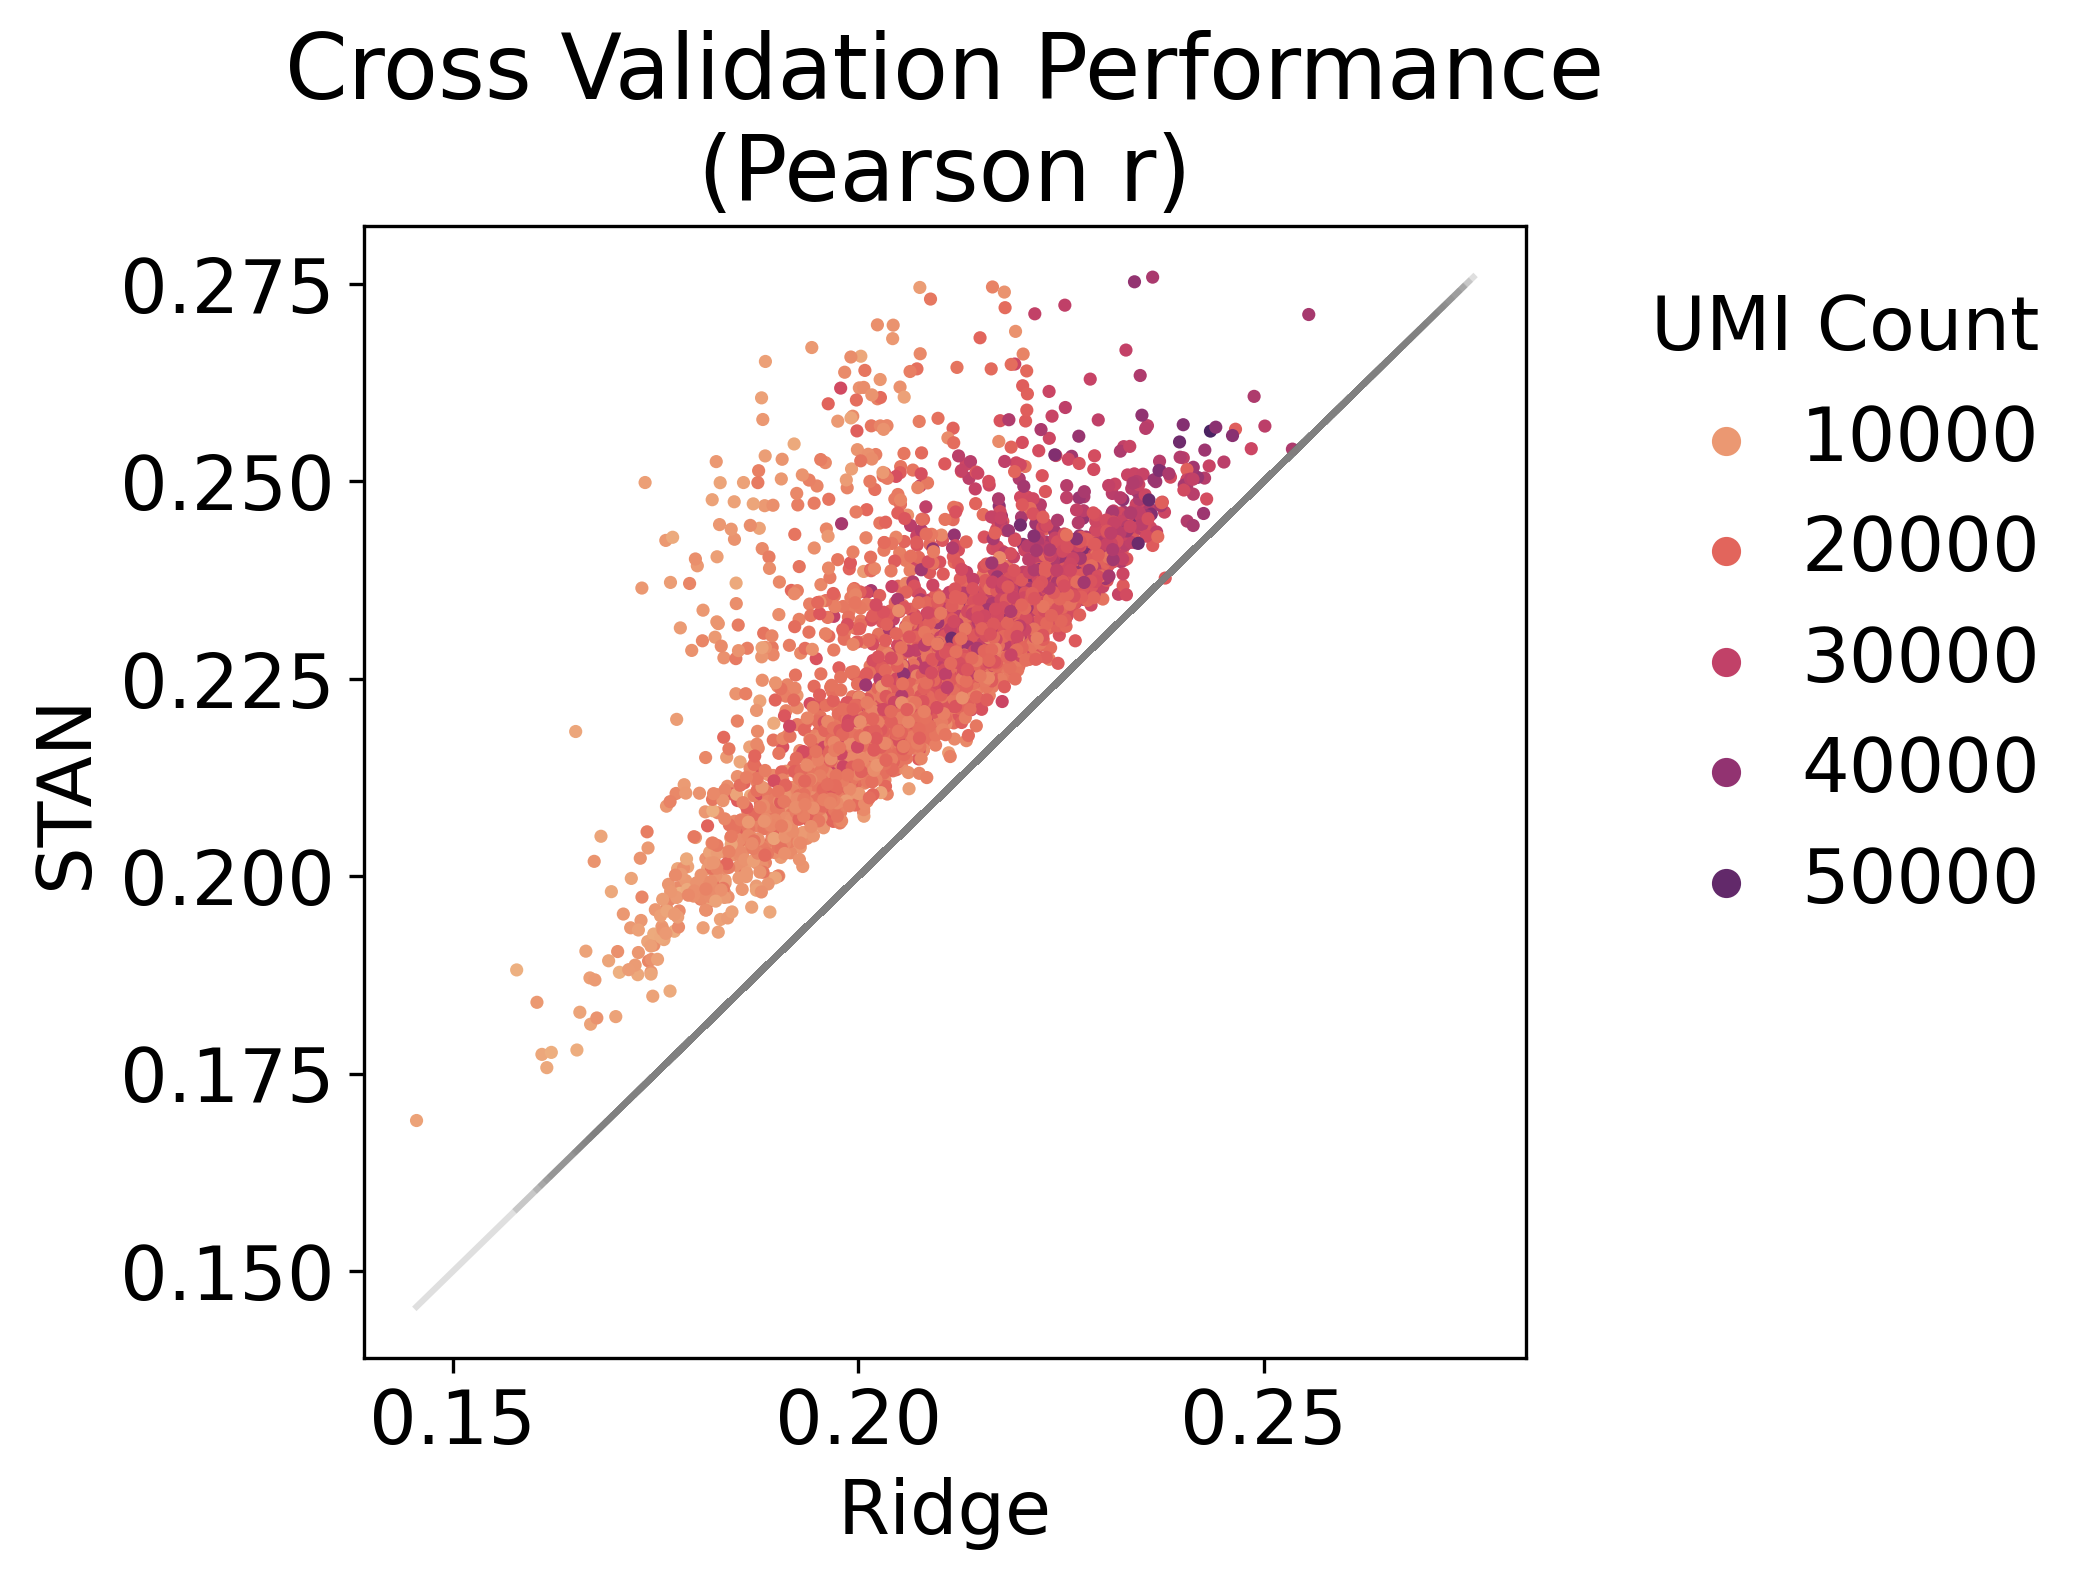

In [19]:
aux.plot_validation(adata)

The increased benefit of spatial information and prediction performance is inversely correlated with the total UMI count per spot.

In [20]:
pearsonr(adata.obs["pred_cor_stan"]-adata.obs["pred_cor_ridge"],
         adata.obs["n_counts"])

PearsonRResult(statistic=-0.20615809562113596, pvalue=1.5278622567231315e-39)

## Saving results to file 

In [21]:
adata.write("outputs_stan/lymphnode_stan.h5ad")

# Analyzing results of STAN: 
# Identifying spatial-domain-specific and cell-type-specific TFs 

In [22]:
# input of STAN
adata_raw = sc.read_h5ad("outputs_stan/lymphnode.h5ad")
# output of STAN
adata_stan = sc.read_h5ad("outputs_stan/lymphnode_stan.h5ad")

Extract the inferred TF activity matrix.

In [23]:
adata_tfa = AnnData(
    X = adata_stan.obsm['tfa_stan'],
    obs = adata_stan.obs,
    obsm = {name: obj for (name, obj) in adata_stan.obsm.items() if "tf" not in name},
    layers = {name: obj for (name, obj) in adata_stan.obsm.items() if "tf" in name})
adata_tfa.uns = adata_stan.uns

For mRNA expression, normalize each spot by total counts over all genes

In [24]:
sc.pp.normalize_total(adata_raw)
adata_raw.layers['scaled'] = np.sqrt(adata_raw.to_df())

sc.pp.normalize_total(adata_stan)
adata_stan.layers['scaled'] = np.sqrt(adata_stan.to_df())

## Embedding and Clustering
Clustering of STAN-predicted TF activities identifies 10 major clusters and the corresponding spatial distribution shows highly distinct features.

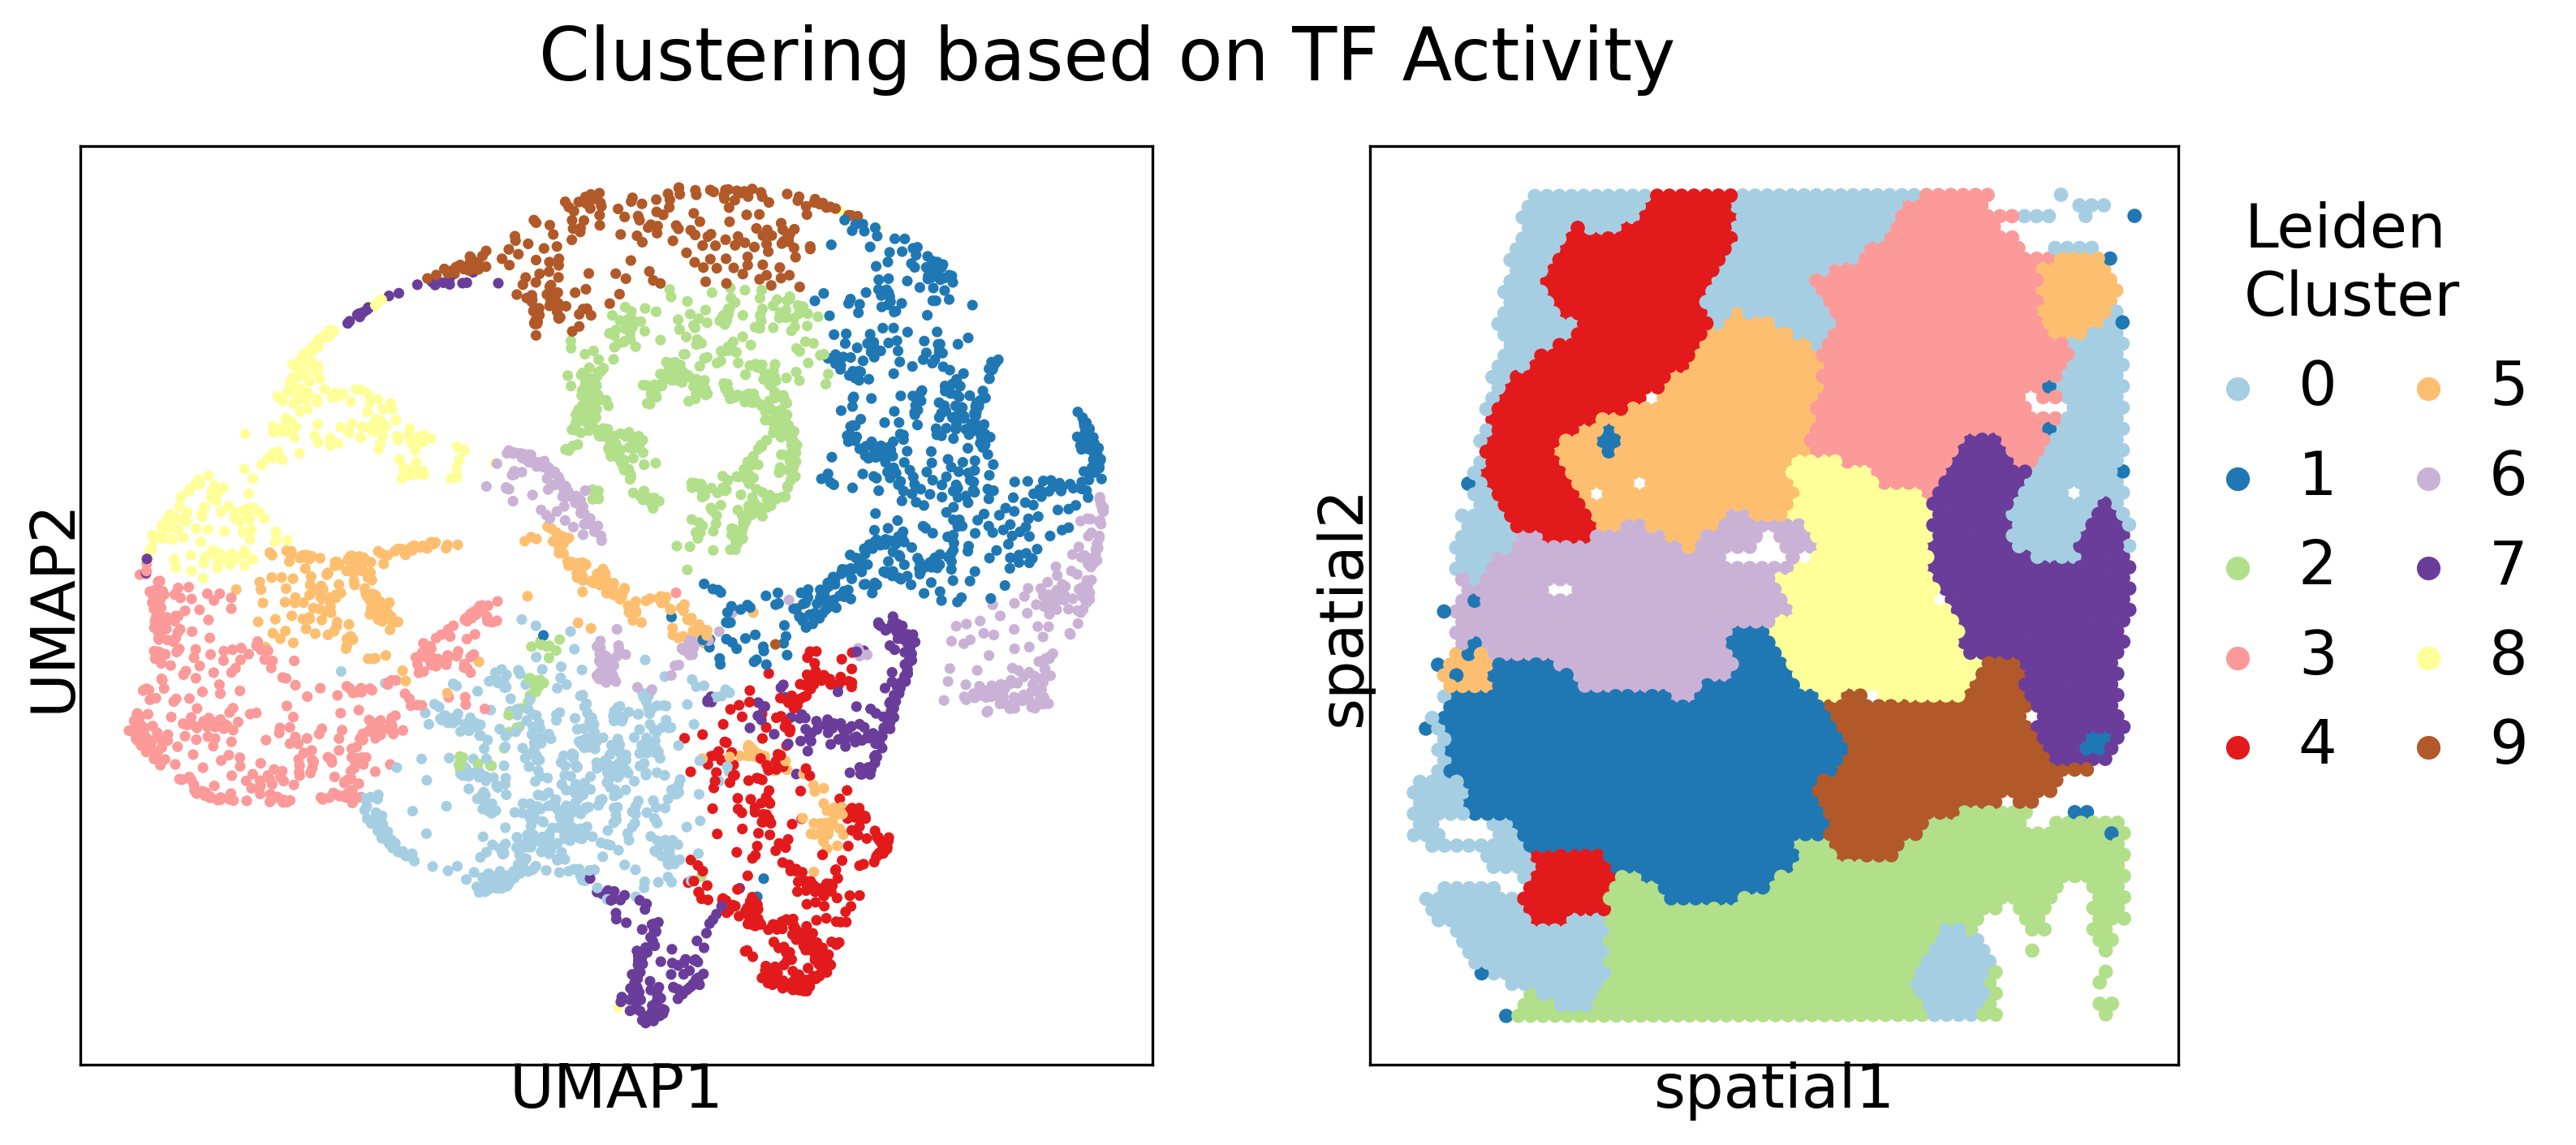

In [29]:
adata_tfa_scaled = adata_tfa.copy()
sc.pp.scale(adata_tfa_scaled)
sc.pp.neighbors(adata_tfa_scaled, use_rep='X', n_neighbors=100)
sc.tl.umap(adata_tfa_scaled, min_dist=0.01)
sc.tl.leiden(adata_tfa_scaled, resolution=0.55)
aux.plot_umap(adata_tfa_scaled, palette='Paired')

The human lymph node is characterized by dynamic microenvironments with many spatially interlaced cell populations, such as germinal centers. Histological examination of the lymph node sample reveals multiple GCs [2].

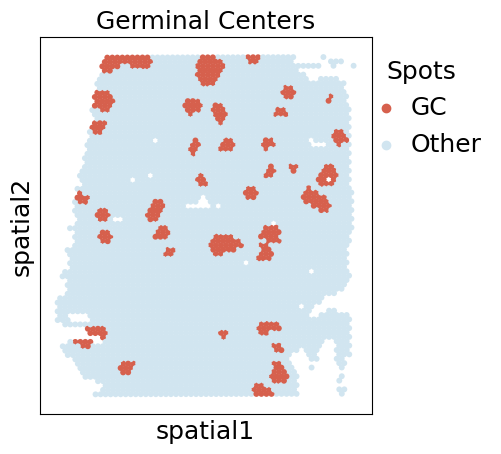

In [26]:
fig, ax = plt.subplots(1,1, figsize=(figsize, figsize), dpi=100)
plt.rc('font', size=fontsize) 
sc.pl.spatial(adata_stan, color='germinal_center', size=1.8, alpha_img=0, 
              palette={"GC":'#d6604d', "Other":'#d1e5f0'},
              ax=ax, show=False, legend_fontsize=fontsize)
ax.set_title('Germinal Centers', fontsize=fontsize)
plt.legend(title="Spots", loc='upper right', bbox_to_anchor=(1.4, 1), columnspacing=0.5, handletextpad=0, frameon=False)

More than half germinal centers are in Cluster 0.

In [30]:
pd.value_counts(adata_tfa_scaled.obs['leiden'][adata_tfa_scaled.obs['germinal_center']=='GC'])

leiden
0    191
8     55
6     39
3     30
2     26
5     21
7      5
4      1
1      0
9      0
Name: count, dtype: int64

## Associating TFs with germinal centers
### Ranking TFs and genes

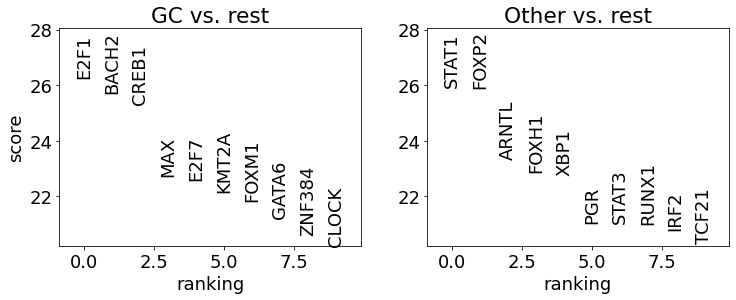

In [28]:
adata_tfa.obs['germinal_center'] = adata_tfa.obs['germinal_center'].astype('category')
sc.tl.rank_genes_groups(adata_tfa, groupby='germinal_center', method="wilcoxon")
sc.pl.rank_genes_groups(adata_tfa, fontsize=fontsize, n_genes=10)

We identify several known TFs associated with GCs.

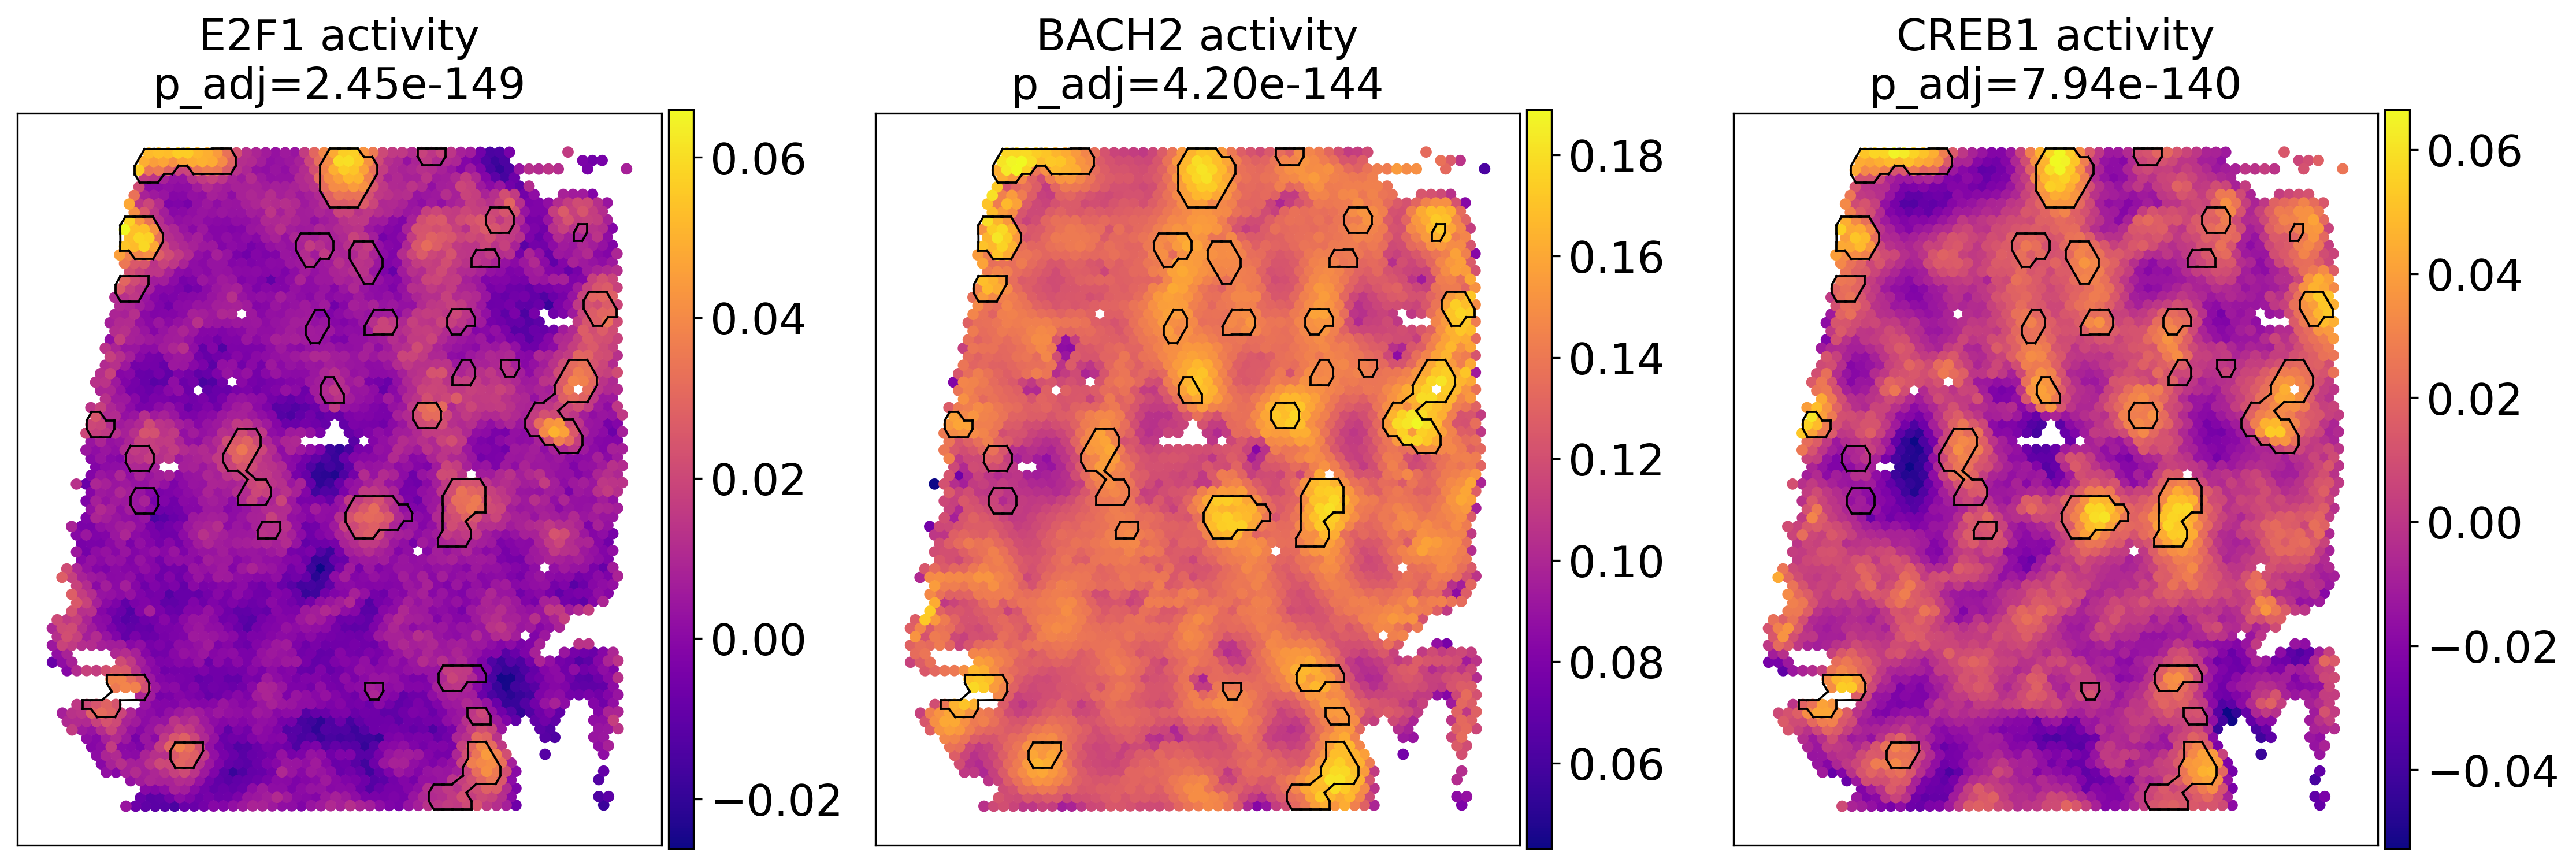

In [31]:
points, edges = aux.find_edges(adata_raw)
aux.plot_spatial_activity(adata_tfa, ['E2F1', 'BACH2', 'CREB1'], points, edges)

We find fewer associations using TF mRNA expression levels directly.

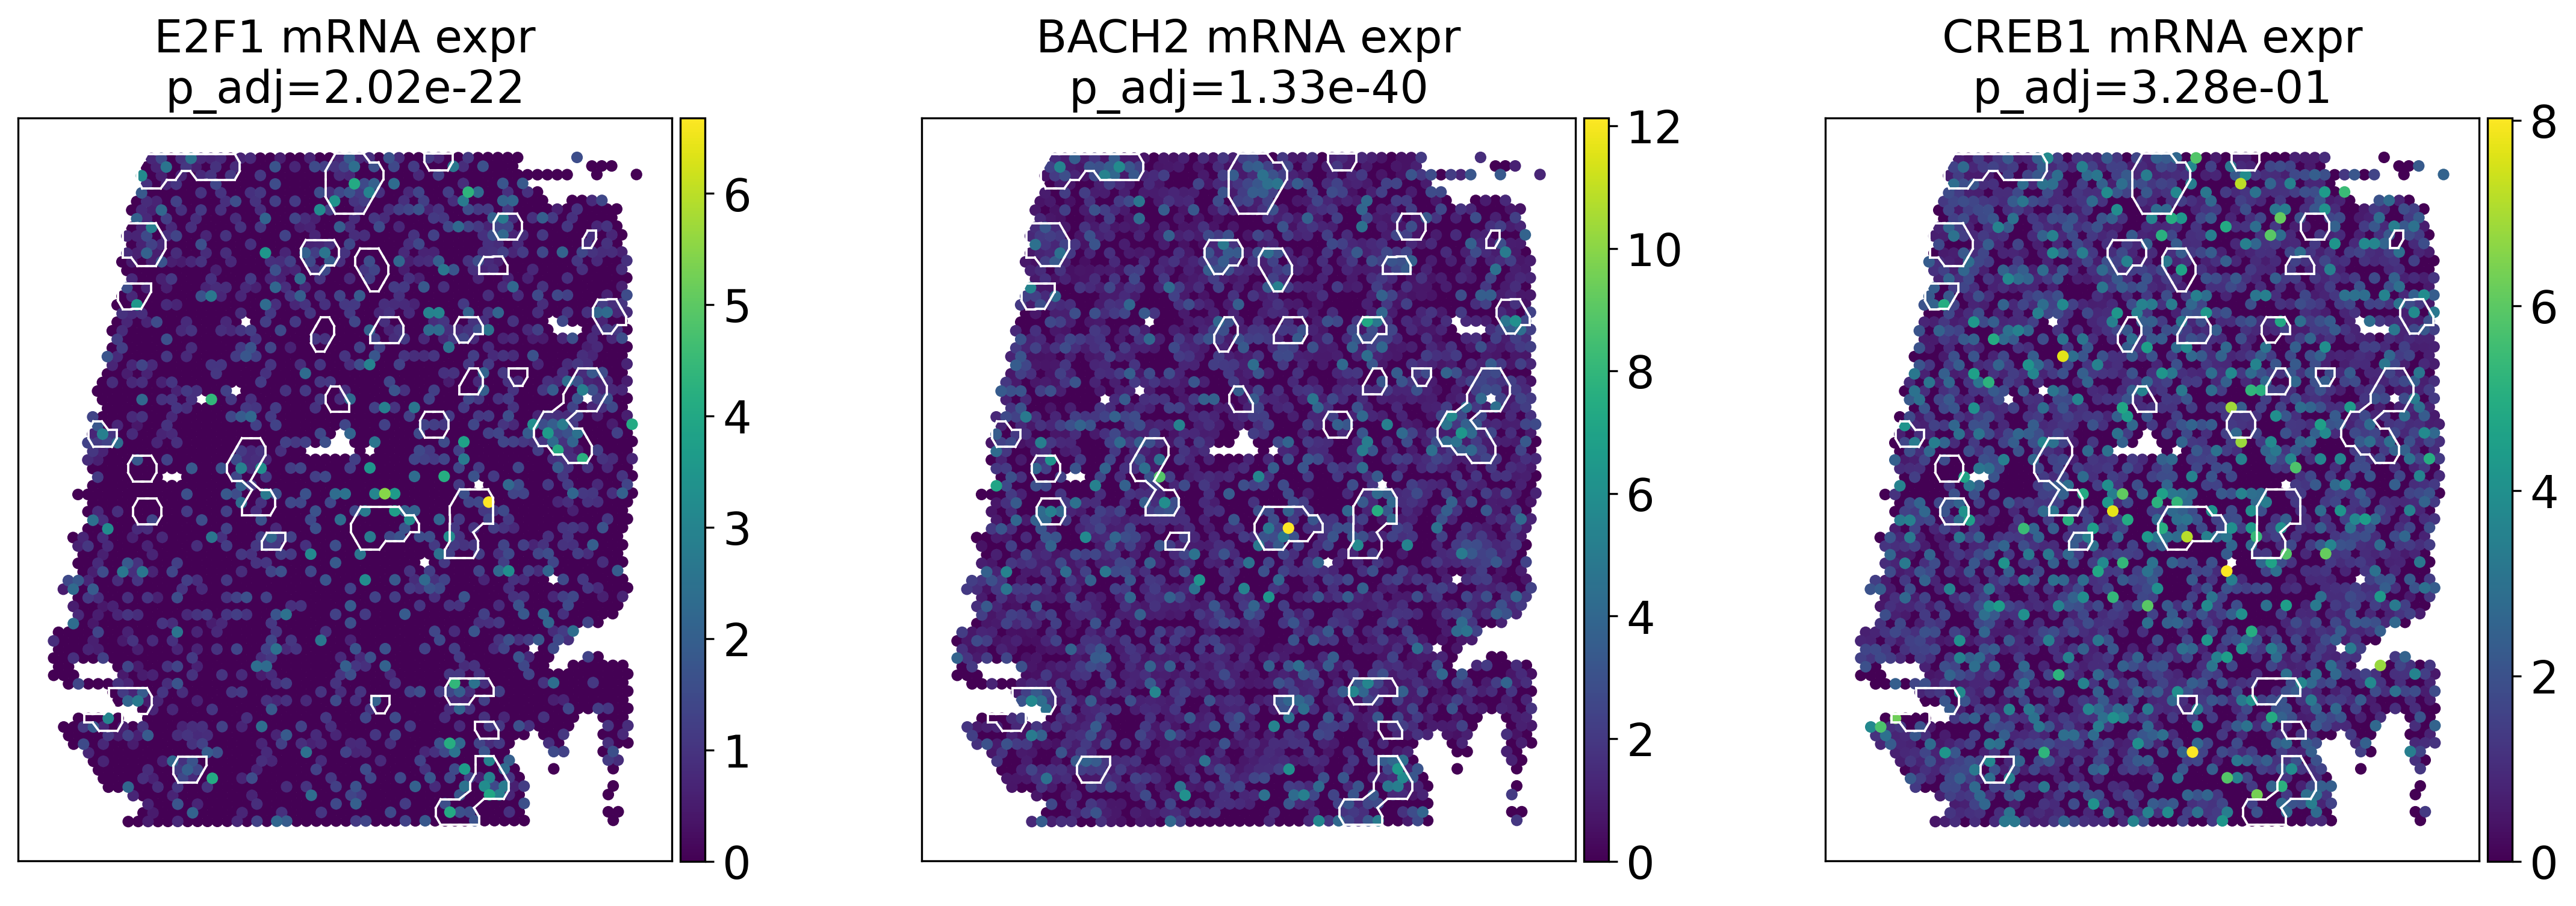

In [32]:
adata_raw.obs['germinal_center'] = adata_raw.obs['germinal_center'].astype('category')
sc.tl.rank_genes_groups(adata_raw, groupby='germinal_center', method="wilcoxon")
aux.plot_spatial_expression(adata_raw, ['E2F1', 'BACH2', 'CREB1'], points, edges)

## Correlating cell type proportion and TF activity

In [33]:
df_celltype = aux.merge_celltypes(adata_raw)
adata_raw.obsm['celltype_major'] = df_celltype
adata_stan.obsm['celltype_major'] = df_celltype
adata_tfa.obsm['celltype_major'] = df_celltype  

In [34]:
df_celltype.head()

B_Cycling      B_GC     B_IFN  B_activated     B_mem  \
AAACAAGTATCTCCCA-1   0.014304  0.015759  0.007460     0.058387  0.066087   
AAACAATCTACTAGCA-1   0.010970  0.016510  0.023918     0.002999  0.004663   
AAACACCAATAACTGC-1   0.016023  0.015284  0.002764     0.053791  0.115564   
AAACAGAGCGACTCCT-1   0.024432  0.019362  0.368534     0.002072  0.001441   
AAACAGCTTTCAGAAG-1   0.004670  0.017024  0.009373     0.037803  0.253315   

                     B_naive  B_plasma   B_preGC        DC      Endo  ...  \
AAACAAGTATCTCCCA-1  0.176268  0.071517  0.034278  0.069290  0.041856  ...   
AAACAATCTACTAGCA-1  0.006454  0.007097  0.029351  0.063063  0.016330  ...   
AAACACCAATAACTGC-1  0.104310  0.035633  0.065812  0.106240  0.051260  ...   
AAACAGAGCGACTCCT-1  0.005292  0.007063  0.030701  0.064255  0.013750  ...   
AAACAGCTTTCAGAAG-1  0.294039  0.010730  0.057246  0.054234  0.008623  ...   

                        Mast  Monocytes        NK       NKT    T_CD4+  \
AAACAAGTATCTCCCA-1  0.003779   0.016134  0.028363  0.011136  0.141394   
AAACAATCTACTAGCA-1  0.003834   0.002375  0.018300  0.005977  0.498832   
AAACACCAATAACTGC-1  0.004406   0.016827  0.034650  0.016146  0.094905   
AAACAGAGCGACTCCT-1  0.005240   0.003143  0.032569  0.004796  0.175668   
AAACAGCTTTCAGAAG-1  0.002345   0.003390  0.007339  0.004948  0.131719   

                      T_CD8+    T_Treg   T_TIM3+     T_TfR      VSMC  
AAACAAGTATCTCCCA-1  0.067074  0.023694  0.053307  0.011292  0.023908  
AAACAATCTACTAGCA-1  0.091670  0.060476  0.038013  0.033988  0.019545  
AAACACCAATAACTGC-1  0.049987  0.010822  0.059203  0.007736  0.022477  
AAACAGAGCGACTCCT-1  0.059437  0.030137  0.054518  0.019565  0.010812  
AAACAGCTTTCAGAAG-1  0.017126  0.007050  0.017947  0.006130  0.006954  

[5 rows x 23 columns]

We compute correlations between spot-specific TF activities / gene expressions and cell-type proportions. 

In [35]:
mat_cor_tfa, mat_cor_rna = aux.make_cor_dataframe(adata_raw, adata_tfa, celltype_label='celltype_major')

In [36]:
mat_cor_tfa.head()

B_Cycling      B_GC     B_IFN  B_activated     B_mem   B_naive  \
AHR     -0.272848 -0.142530 -0.088106     0.117679 -0.079208  0.131748   
AR      -0.157130  0.049056  0.057286     0.138913 -0.253435  0.160672   
ARID3A  -0.060623 -0.143739 -0.238306     0.103842  0.325197 -0.162121   
ARNT    -0.290109 -0.166381 -0.103205     0.343048 -0.087206  0.164797   
ARNTL   -0.465338 -0.431296 -0.086581     0.156578 -0.072323 -0.024163   

        B_plasma   B_preGC        DC      Endo  ...      Mast  Monocytes  \
AHR     0.076754 -0.137187 -0.186001  0.016094  ... -0.032545   0.048890   
AR      0.100193 -0.286341 -0.244090  0.040244  ... -0.047424   0.059602   
ARID3A  0.086128  0.152606  0.304680  0.255605  ...  0.168789   0.223548   
ARNT    0.350567 -0.142560 -0.160753  0.193572  ...  0.012733   0.214862   
ARNTL   0.251321 -0.000953 -0.046714  0.181460  ...  0.030289   0.195770   

              NK       NKT    T_CD4+    T_CD8+    T_Treg   T_TIM3+     T_TfR  \
AHR     0.163162 -0.017191  0.106637  0.257492  0.228050  0.024098  0.115393   
AR      0.298189 -0.045775 -0.017441  0.255766  0.214760  0.087242  0.071659   
ARID3A -0.190057  0.242271 -0.051645 -0.200365 -0.235362 -0.270481 -0.137047   
ARNT    0.279010  0.097533 -0.094593  0.201071  0.073915  0.082769 -0.084830   
ARNTL   0.181032  0.151032  0.210809  0.380945  0.312496  0.093346  0.224795   

            VSMC  
AHR     0.008416  
AR      0.028210  
ARID3A  0.257143  
ARNT    0.282721  
ARNTL   0.253228  

[5 rows x 23 columns]

In [37]:
mat_cor_rna.head()

B_Cycling      B_GC     B_IFN  B_activated     B_mem   B_naive  \
AHR      0.009223 -0.000835 -0.010662    -0.023063  0.063908 -0.060321   
AR      -0.009376 -0.010489 -0.017858     0.001706  0.008719 -0.002219   
ARID3A  -0.055220 -0.075344  0.011635     0.051627  0.002791  0.021276   
ARNT    -0.030451 -0.012786 -0.022875     0.015264  0.028499  0.014650   
ARNTL   -0.043328 -0.028302 -0.000723    -0.010249 -0.051037  0.009817   

        B_plasma   B_preGC        DC      Endo  ...      Mast  Monocytes  \
AHR    -0.063801  0.040088  0.150313  0.119125  ...  0.081089   0.031334   
AR     -0.009217 -0.011876  0.007907  0.038644  ... -0.001375   0.013970   
ARID3A  0.060188  0.057354  0.016473  0.031431  ...  0.034463   0.018450   
ARNT   -0.013350  0.004472 -0.000996  0.041280  ... -0.007123   0.037205   
ARNTL  -0.018236 -0.019914 -0.021207 -0.012650  ...  0.001419   0.012348   

              NK       NKT    T_CD4+    T_CD8+    T_Treg   T_TIM3+     T_TfR  \
AHR    -0.064529  0.063505 -0.038818 -0.076397 -0.062192 -0.029661 -0.013476   
AR     -0.018990  0.028066 -0.000555  0.010018  0.000673 -0.015991  0.006417   
ARID3A  0.032617  0.014080 -0.027219  0.008611 -0.013244  0.066422 -0.028671   
ARNT   -0.014431  0.011950 -0.002681 -0.012970 -0.004977 -0.025344  0.004242   
ARNTL   0.044289 -0.024363  0.037909  0.083752  0.078833  0.060272  0.056722   

            VSMC  
AHR     0.052146  
AR      0.046093  
ARID3A  0.018042  
ARNT    0.020302  
ARNTL  -0.006029  

[5 rows x 23 columns]

We observe high correlation for several known cell-type-specific TFs.

In [38]:
def plot_spatial_ct_tf(ct, tf):
    fig, axs = plt.subplots(1,3, figsize=(figsize*3,figsize), dpi=100)
    sc.pl.spatial(sq.pl.extract(adata_tfa, "celltype_major"),
                  color=ct, alpha_img=0, ax=axs[0], show=False, cmap="rocket", size=1.8,
                  legend_fontsize=fontsize)
    sc.pl.spatial(adata_tfa, color=tf, alpha_img=0, ax=axs[1],show=False, cmap="plasma", 
                  legend_fontsize=fontsize, size=1.8)
    sc.pl.spatial(adata_raw, color=tf, alpha_img=0, ax=axs[2],show=False, cmap="viridis", 
                  legend_fontsize=fontsize, size=1.8)

    axs[0].set_title(ct+'\n', fontsize=fontsize)
    axs[1].set_title(tf+' activity\npearson=%.4f'% mat_cor_tfa.loc[tf, ct], fontsize=fontsize)
    axs[2].set_title(tf+" mRNA expr\npearson=%.4f"% mat_cor_rna.loc[tf, ct], fontsize=fontsize)
    for i in range(3):
        axs[i].set_xlabel("")
        axs[i].set_ylabel("")
    plt.tight_layout(pad=0.6)

FOXP3 is a master TF that regulates the regulatory T cell development and function, and FOXP3 activity is highly correlated with Treg cell type proportion.

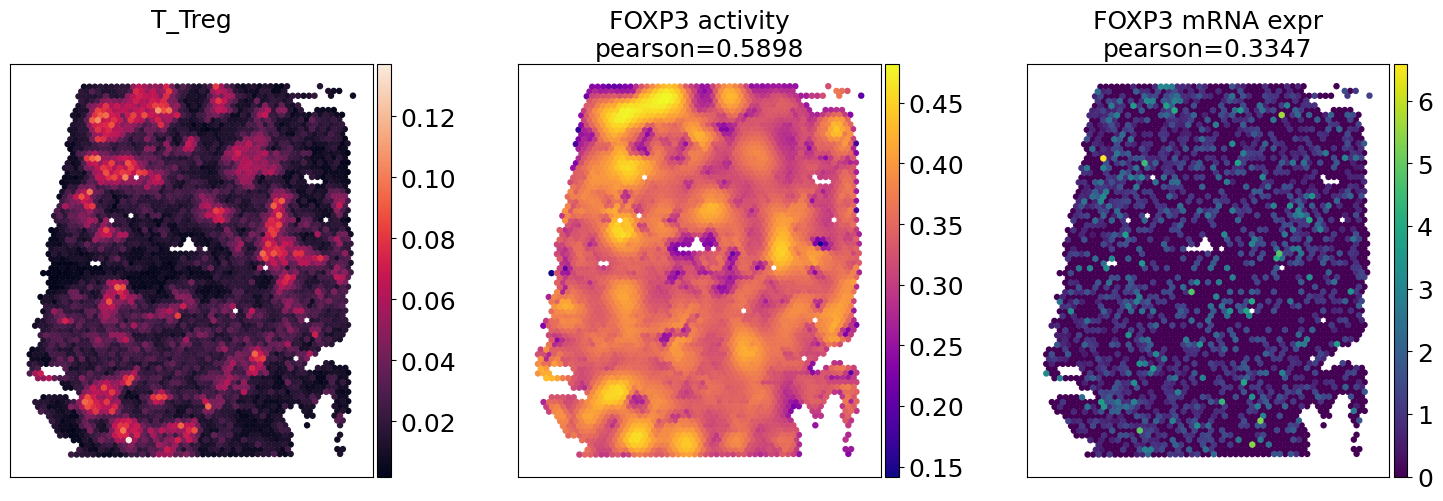

In [39]:
plot_spatial_ct_tf(ct = "T_Treg", tf = "FOXP3")

STAT2 is essential for immune responses involving Type 1 interferons, and STAT2 activity is highly correlated with cells expressing IFN-$\beta$.

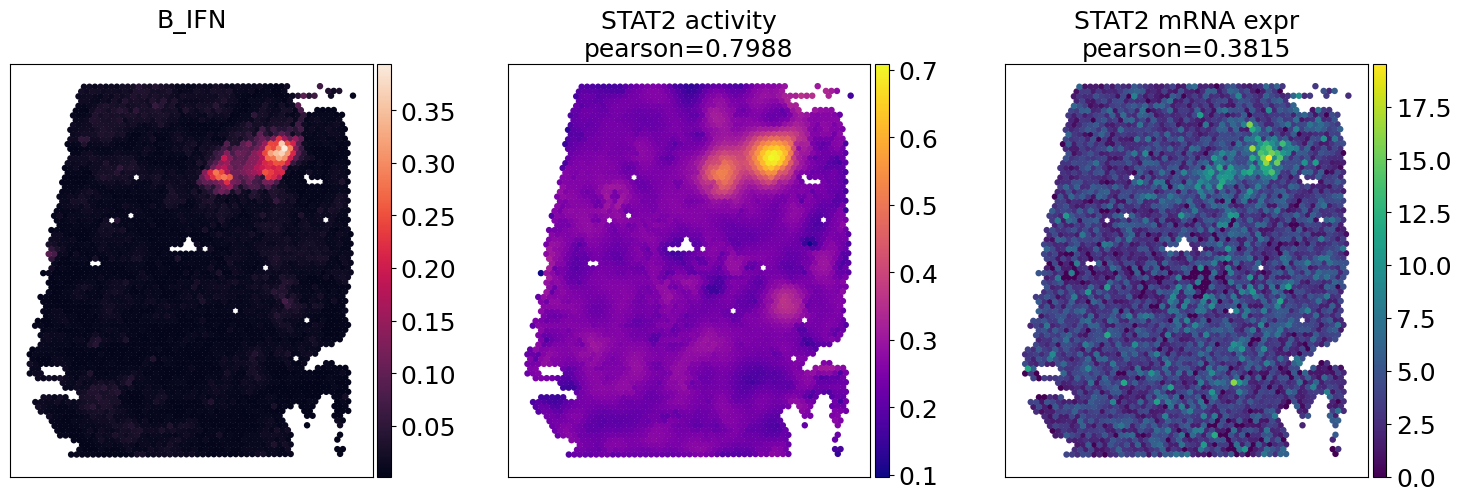

In [40]:
plot_spatial_ct_tf(ct = "B_IFN", tf = "STAT2")

## Identifying cell-type-specific TFs
We model the relationship between estimated cell type proportions and TF activities using linear regression, and obtain the TF score for each cell type across spots.

In [41]:
df_ct_tf = aux.make_ct_tf_dataframe(adata_tfa, celltype_label='celltype_major')

In [42]:
df_ct_tf.head()

tf           ct      coef             p        SE  r_squared  \
0  AHR    B_Cycling -4.914071  2.658044e-15  0.619076   0.155274   
1  AHR         B_GC -0.043717  9.516518e-01  0.720975   0.155274   
2  AHR        B_IFN -2.578180  7.559758e-07  0.520387   0.155274   
3  AHR  B_activated  8.454006  6.986878e-06  1.878626   0.155274   
4  AHR        B_mem  0.346480  3.826937e-01  0.396865   0.155274   

          p_adj  negative_log_p_adj  
0  4.219939e-14            9.999817  
1  9.671054e-01            0.014526  
2  4.427270e-06            5.353854  
3  3.485021e-05            4.457793  
4  4.922699e-01            0.307797

### Visualization
We identify several novel and known TF-cell type relationships in the lymph node sample:
- FOXP3 for Tregs,
- BACH2 for B and T cells,
- IRF1, IRF2, and STAT2 for TIM+ T cells and cells expressing IFN-$\beta$.

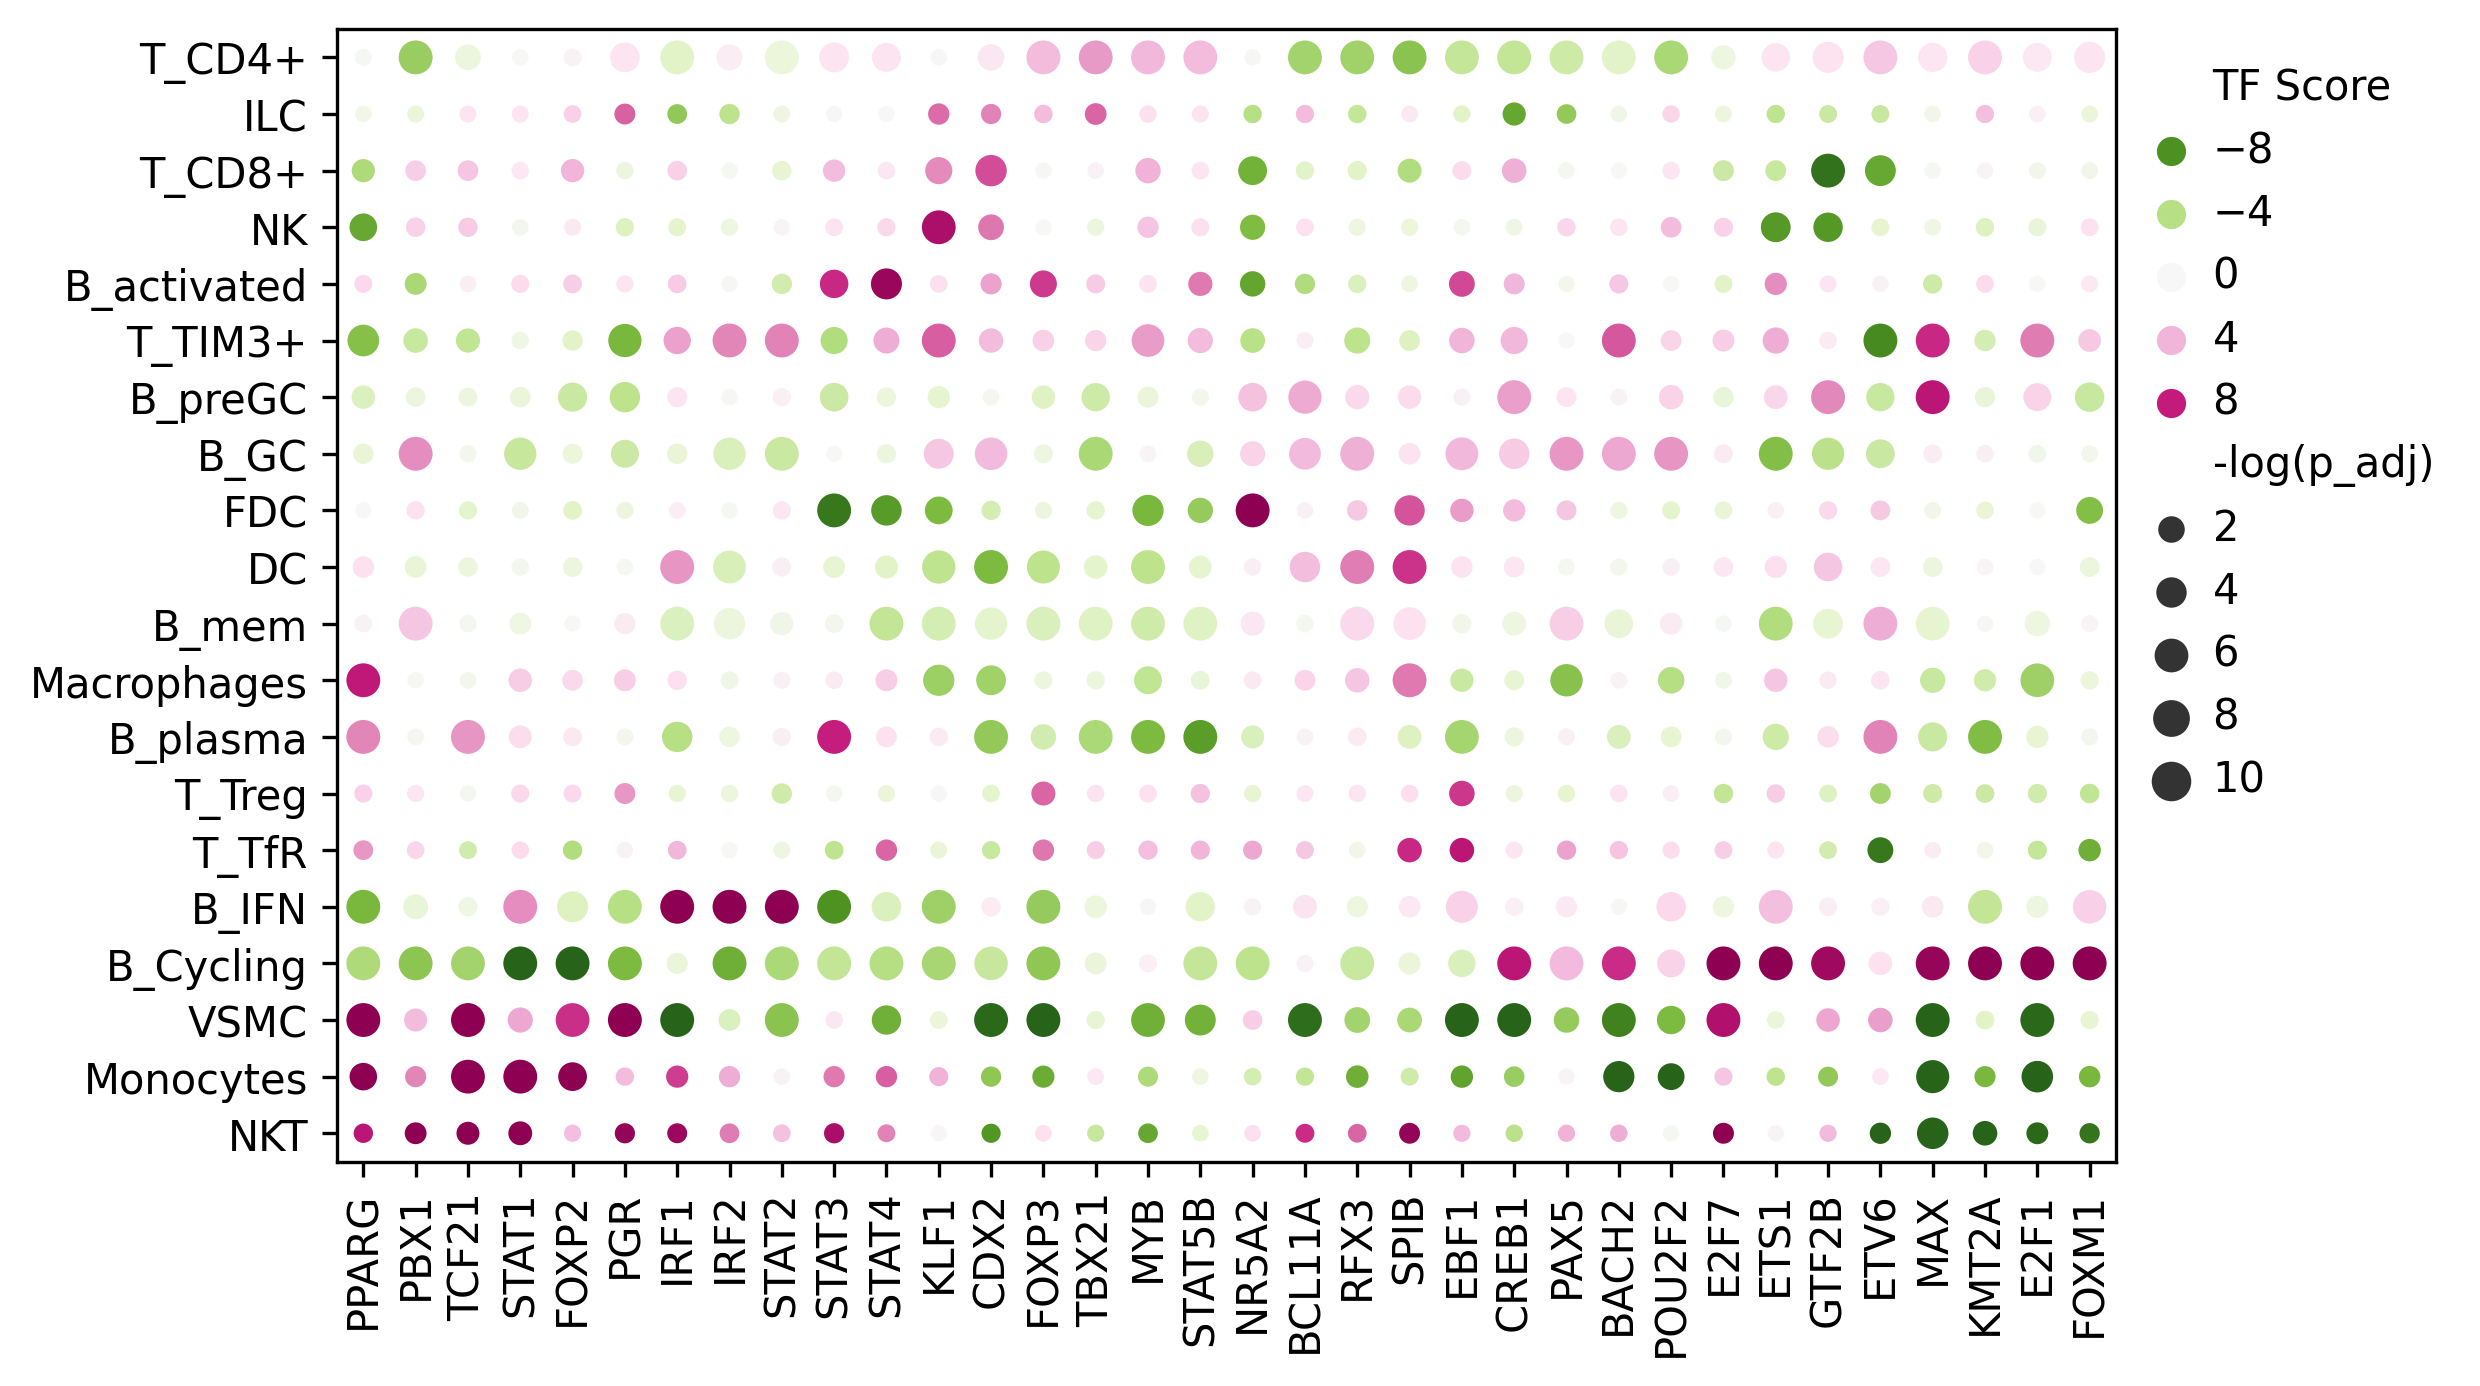

In [43]:
df_filtered = df_ct_tf.query("negative_log_p_adj>2").query('coef>4').query("r_squared>0.4")
tf_list = df_filtered['tf'].unique()
ct_list = df_filtered['ct'].unique()
aux.plot_heatmap(df_ct_tf, tf_list, ct_list)

# Summary
STAN leverages parallel spot-specific **ST data** and imaging data with cis-regulatory information (e.g., TF-target gene priors) to predict **spatially informed TF activities**. Applications of STAN include:
- deciphering critical TF regulators underlying cell identities, spatial domains (e.g., GCs), and pathological regions (e.g., stroma vs. tumor);
- determining whether a given pathological region/spatial domain has different and/or common regulators across disease subtypes;
- identifying similar and/or different TFs associated with spatial domains or cell types across healthy individuals and those manifesting a disease; 
- linking ligands and receptors to TFs for elucidating potential signaling pathways and regulatory networks involved in cellular communication and tissue microenvironment interactions.

More examples for the applications can be found [here](https://github.com/osmanbeyoglulab/stan).